In [7]:
import pandas as pd
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/archive')
# file = (path + 'labels.csv')
# df = pd.read_csv(file)
# df.head()

In [2]:
# df.describe()

In [3]:
# df.hist

In [4]:
# df.info()

In [14]:
import os
# Define an empty list
file_counts = []
def countFile(link):
    path = link
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    file_counts.append(num_files)
    print(f"Number of files in directory {link} is ", num_files)

In [15]:
countFile("archive/happy")
countFile("archive/sad")
countFile("archive/surprise")
countFile("archive/anger")
countFile("archive/disgust")
countFile("archive/fear")
countFile("archive/neutral")

Number of files in directory archive/happy is  5044
Number of files in directory archive/sad is  3091
Number of files in directory archive/surprise is  4039
Number of files in directory archive/anger is  3218
Number of files in directory archive/disgust is  2477
Number of files in directory archive/fear is  3176
Number of files in directory archive/neutral is  5126


In [16]:
file_counts

[5044, 3091, 4039, 3218, 2477, 3176, 5126]

In [ ]:
# # display random images
# import random
# import cv2

# fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
#                         figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
# fig.suptitle("Sample Faces and Labels")
# axs = axs.flatten()

# for i in range(7):
#     idx = random.randint(0, len(df)-1)  # randomly select an index
#     img_path = path + df['pth'][idx]
#     img = cv2.imread(img_path)  # read image
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
#     axs[i].imshow(img)
#     axs[i].set_title(df['label'][idx])

In [19]:
# how many emotions categories

import os

INPUT_PATH = "archive"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [20]:
# define functions to pre-process and load images into arrays

import cv2
import numpy as np
from keras.utils import to_categorical
import os

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

In [21]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

In [23]:
input_shape

(96, 96, 3)

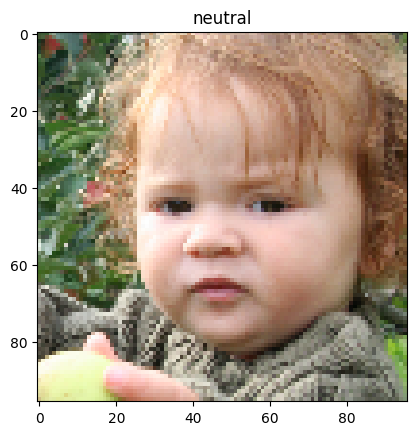

In [24]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()

In [25]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Model 1

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

In [27]:
y_test.shape

(5235, 7)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model.fit(X_train, y_train, batch_size=128,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/10
164/164 [==============================] - 410s 2s/step - loss: 3.7411 - accuracy: 0.3117 - val_loss: 2.6207 - val_accuracy: 0.4155 - lr: 0.0010
Epoch 2/10
164/164 [==============================] - 423s 3s/step - loss: 2.3534 - accuracy: 0.4444 - val_loss: 1.7825 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - 418s 3s/step - loss: 1.7015 - accuracy: 0.5149 - val_loss: 1.4089 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 4/10
164/164 [==============================] - 568s 3s/step - loss: 1.3687 - accuracy: 0.5477 - val_loss: 1.2198 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 5/10
164/164 [==============================] - 4993s 31s/step - loss: 1.1986 - accuracy: 0.5811 - val_loss: 1.1018 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 6/10
164/164 [==============================] - 23082s 142s/step - loss: 1.1120 - accuracy: 0.5971 - val_loss: 1.0687 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 7/10
164/164 [==============================] - 2003

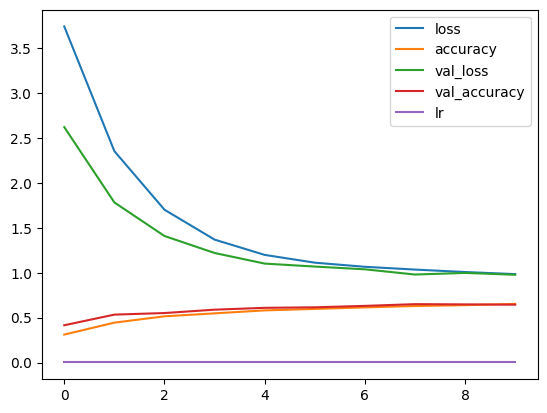

In [29]:
pd.DataFrame(history.history).plot();

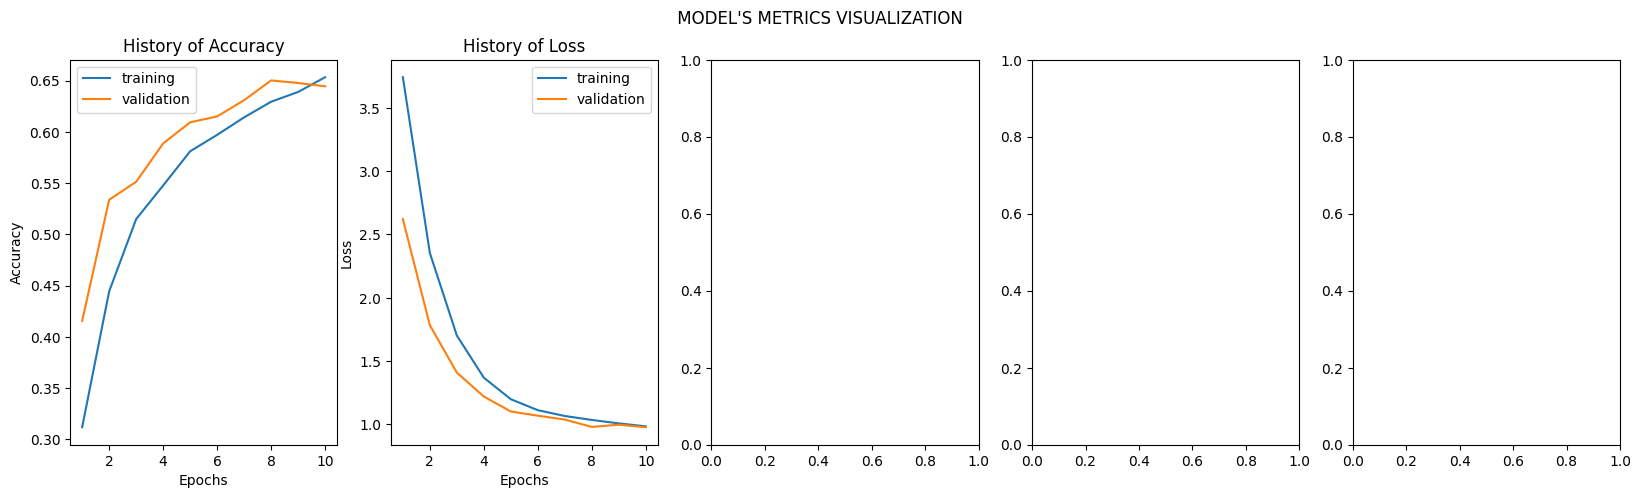

In [30]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
              )

164/164 [==============================] - 19s 116ms/step


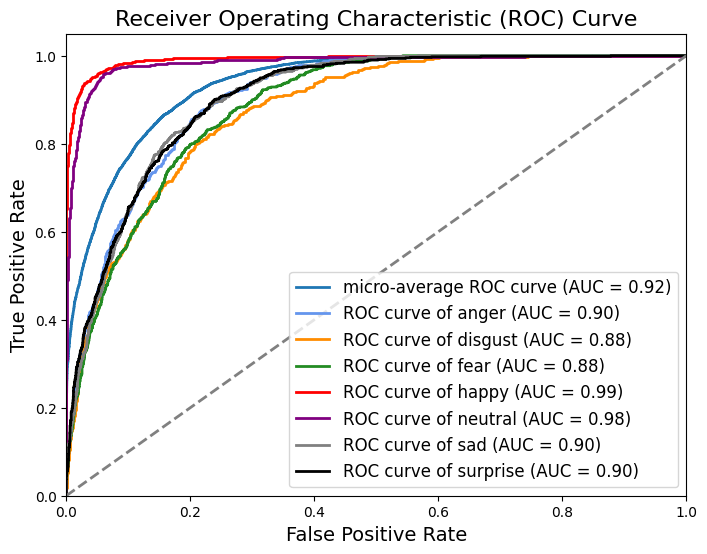

In [31]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [32]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

164/164 [==============================] - 20s 121ms/step
              precision    recall  f1-score   support

           0       0.63      0.29      0.40       640
           1       0.47      0.46      0.46       486
           2       0.61      0.18      0.28       661
           3       0.95      0.86      0.90       969
           4       0.84      0.92      0.88      1022
           5       0.46      0.70      0.55       643
           6       0.48      0.76      0.59       814

    accuracy                           0.64      5235
   macro avg       0.64      0.60      0.58      5235
weighted avg       0.67      0.64      0.63      5235



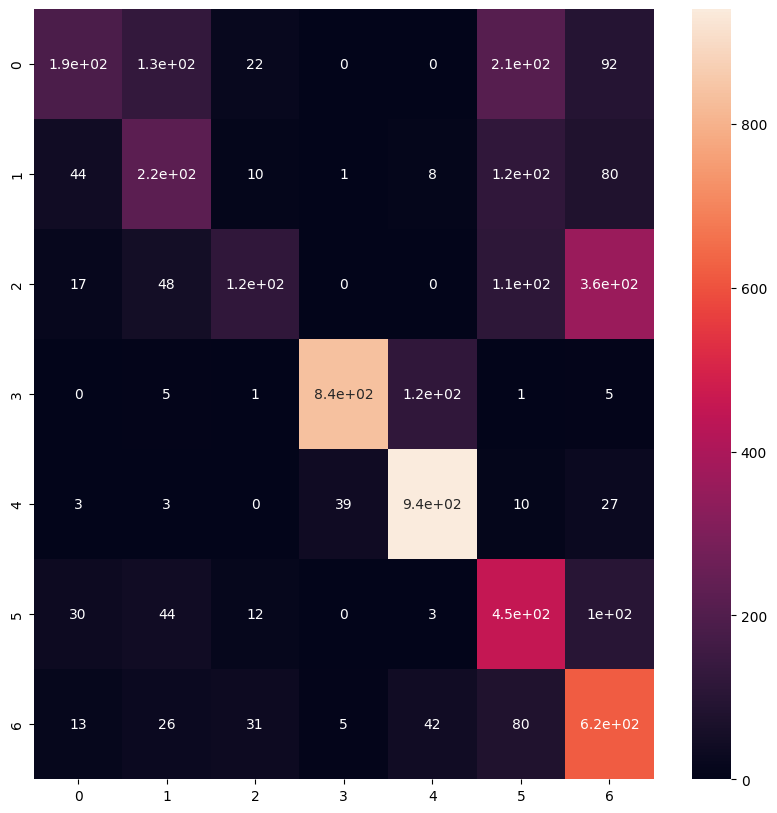

In [33]:
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix
plt.figure(figsize=(10, 10))
cm=confusion_matrix(y_test_int, y_pred_int)
sns.heatmap(cm, annot=True)
plt.show()

In [34]:
# save the model
model.save('/kaggle/working/model_4.h5')

## Model 2

In [35]:
from keras.models import Model
from keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D, Dense, Add
from keras.optimizers import Adam

inputs = Input(shape=input_shape)

# First Conv Block
x = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

# Second Conv Block
x = SeparableConv2D(64, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = SeparableConv2D(64, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)

# Residual-like connection
residual = Conv2D(128, (1,1), padding="same")(x)
x = SeparableConv2D(128, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Adding residual connection
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

# Fourth Conv Block
x = SeparableConv2D(256, (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)

# Global Average Pooling instead of Flatten
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(128, activation="relu", kernel_regularizer="l2")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(7, activation="softmax")(x)

# Create Model
model2 = Model(inputs, outputs)

# Compile Model
model2.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Model Summary
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 96, 96, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 96, 96, 32)  128         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 48, 32)  0           ['batch_normalization_8[0][0]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model2.fit(X_train, y_train, batch_size=128,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/10
164/164 [==============================] - 249s 2s/step - loss: 3.4292 - accuracy: 0.2079 - val_loss: 3.0940 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 2/10
164/164 [==============================] - 1532s 9s/step - loss: 2.2903 - accuracy: 0.2885 - val_loss: 2.7039 - val_accuracy: 0.1841 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - 245s 1s/step - loss: 1.7816 - accuracy: 0.3191 - val_loss: 1.9483 - val_accuracy: 0.3074 - lr: 0.0010
Epoch 4/10
164/164 [==============================] - 465s 3s/step - loss: 1.5688 - accuracy: 0.3252 - val_loss: 2.0552 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 5/10
164/164 [==============================] - ETA: 0s - loss: 1.4606 - accuracy: 0.3408
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
164/164 [==============================] - 374s 2s/step - loss: 1.4606 - accuracy: 0.3408 - val_loss: 2.2836 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 6/10
164/164 [==============================] - 410s

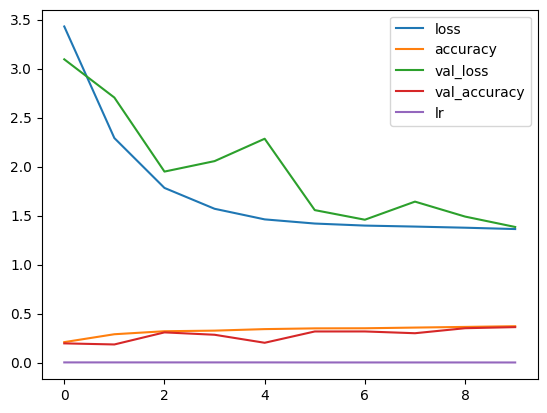

In [37]:
pd.DataFrame(history.history).plot();

164/164 [==============================] - 10s 60ms/step


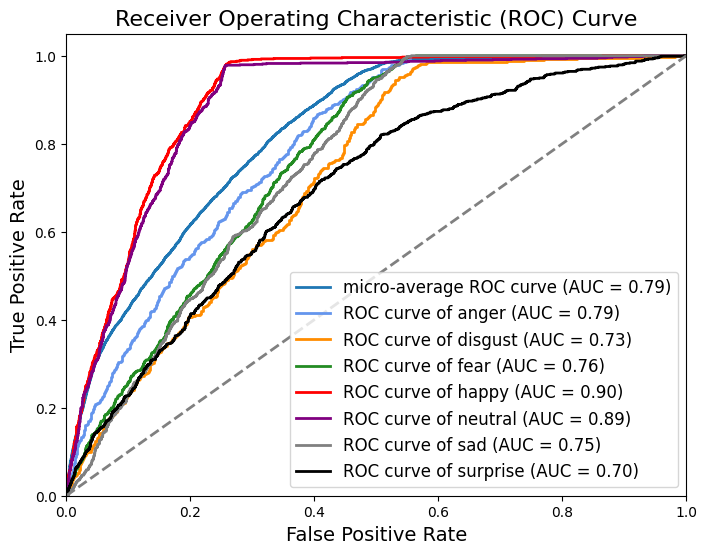

In [38]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model2.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [39]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

164/164 [==============================] - 10s 62ms/step
              precision    recall  f1-score   support

           0       0.42      0.10      0.16       640
           1       0.00      0.00      0.00       486
           2       0.22      0.80      0.35       661
           3       0.56      0.49      0.53       969
           4       0.55      0.63      0.59      1022
           5       0.17      0.02      0.04       643
           6       0.26      0.19      0.22       814

    accuracy                           0.36      5235
   macro avg       0.31      0.32      0.27      5235
weighted avg       0.35      0.36      0.32      5235



c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Model3 - MobileNetV2

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model3 = Model(inputs=base_model.input, outputs=output)
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model3.summary()

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model3.fit(X_train, y_train, batch_size=128,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/10
164/164 [==============================] - 59s 362ms/step - loss: 1.5737 - accuracy: 0.3642 - val_loss: 1.6059 - val_accuracy: 0.3479 - lr: 2.5000e-04
Epoch 2/10
164/164 [==============================] - 62s 381ms/step - loss: 1.5640 - accuracy: 0.3688 - val_loss: 1.6108 - val_accuracy: 0.3500 - lr: 2.5000e-04
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.5619 - accuracy: 0.3710
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
164/164 [==============================] - 64s 388ms/step - loss: 1.5619 - accuracy: 0.3710 - val_loss: 1.6116 - val_accuracy: 0.3536 - lr: 2.5000e-04
Epoch 4/10
164/164 [==============================] - 66s 400ms/step - loss: 1.5526 - accuracy: 0.3799 - val_loss: 1.6054 - val_accuracy: 0.3559 - lr: 1.2500e-04
Epoch 5/10
164/164 [==============================] - 67s 411ms/step - loss: 1.5482 - accuracy: 0.3793 - val_loss: 1.6049 - val_accuracy: 0.3507 - lr: 1.2500e-04
Epoch 6/10
164/164 [=========

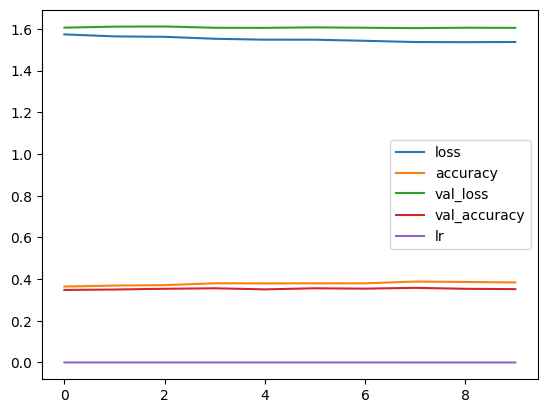

In [43]:
pd.DataFrame(history.history).plot();

164/164 [==============================] - 11s 64ms/step


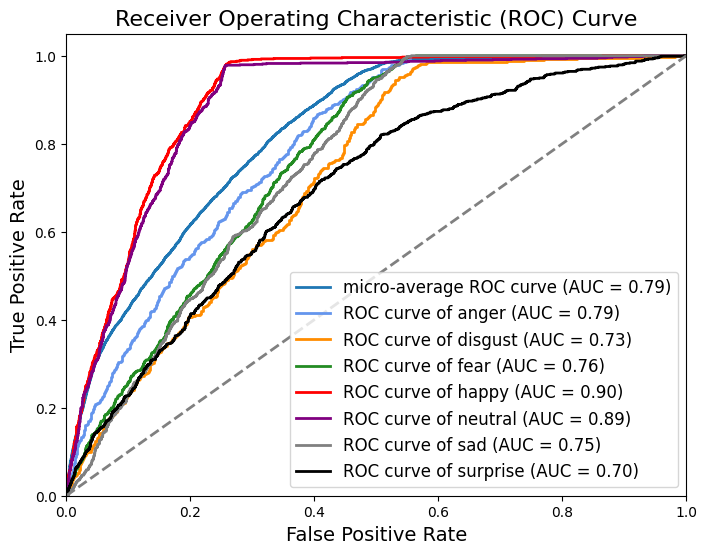

In [44]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model2.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [45]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

164/164 [==============================] - 11s 68ms/step
              precision    recall  f1-score   support

           0       0.42      0.10      0.16       640
           1       0.00      0.00      0.00       486
           2       0.22      0.80      0.35       661
           3       0.56      0.49      0.53       969
           4       0.55      0.63      0.59      1022
           5       0.17      0.02      0.04       643
           6       0.26      0.19      0.22       814

    accuracy                           0.36      5235
   macro avg       0.31      0.32      0.27      5235
weighted avg       0.35      0.36      0.32      5235



c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif